In [12]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
import numpy as np
import os
import random
import torch
import torch.nn as nn
import re

In [2]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [103]:
#dataloader for images with background in grayscale or RGB
# Input greyscale=True if we feed loader with greyscale images

class SegmentationDataset(Dataset):
    def __init__(self, folder1_path,folder2_path, greyscale = False, transform=None):
        self.folder1_path = folder1_path
        self.folder2_path = folder2_path
        self.transform = transform
        self.gs = greyscale
        #self.file_names = [f for f in os.listdir(folder_path)]
        self.file_names = [os.path.join(folder1_path, f) for f in os.listdir(folder1_path)] + \
                          [os.path.join(folder2_path, f) for f in os.listdir(folder2_path)]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        #file_path = os.path.join(self.folder_path, self.file_names[idx])
        file_path = self.file_names[idx]
        array = np.load(file_path)




        # Convert arrays to PyTorch tensors
        if self.gs:
          image = array[:, :, 0]
          #Min-max normalization
          image = (image - np.min(image)) / (np.max(image) - np.min(image))
          image = torch.from_numpy(image).unsqueeze(0).float()

          label = array[:, :, 1]//10
          label = torch.from_numpy(label).long()  # Convert to long as it's a label
        else:
          image = array[:, :, 0:3]
          #Min-max normalization
          image = (image - np.min(image)) / (np.max(image) - np.min(image))
          image = torch.from_numpy(image).permute(2, 0, 1).float()  # Convert to (C, H, W) format

          label = array[:, :, 3]//10
          label = torch.from_numpy(label).long()  # Convert to long as it's a label

        # Apply transforms if any
        if self.transform is not None:
            image = self.transform(image)

        return image, label





array_path1 = '/content/drive/My Drive/Skoli/6H/Deep Learning/Final Project/carseg_data_2/arrays_reduced'
array_path2 = '/content/drive/My Drive/Skoli/6H/Deep Learning/Final Project/carseg_data_2/arrays_reduced_augmented'


dataset = SegmentationDataset(folder1_path=array_path1,folder2_path=array_path2)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


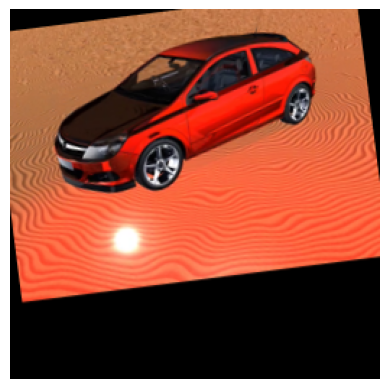

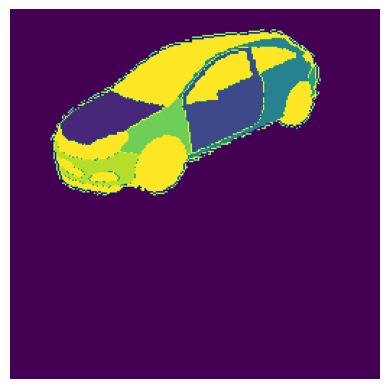

(256, 256, 3)


In [104]:
#visualize dataloader
import matplotlib.pyplot as plt

images, masks = next(iter(dataloader))

# Plot image
img_car = images[0].permute(1, 2, 0).numpy()


img_mask = masks[0].numpy()

plt.imshow(img_car,cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(img_mask)
plt.axis('off')
plt.show()


print(img_car.shape)

In [105]:

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Contracting path
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expanding path
        self.up1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128 + 64, 64)
        self.up2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(64 + 32, 32)

        self.out = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        c1 = self.enc1(x)
        p1 = self.pool(c1)

        c2 = self.enc2(p1)
        p2 = self.pool(c2)

        c3 = self.enc3(p2)

        # Expanding path
        up1 = self.up1(c3)
        merge1 = torch.cat([up1, c2], dim=1)
        d1 = self.dec1(merge1)

        up2 = self.up2(d1)
        merge2 = torch.cat([up2, c1], dim=1)
        d2 = self.dec2(merge2)

        out = self.out(d2)
        return out

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

# Create the model
model = UNet(in_channels=3, out_channels=9)
print(model)


UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up1): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
  (dec1): Sequential(
    (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d

In [106]:
import torch.optim as optim
from tqdm.notebook import tqdm

# Assuming you have a dataloader 'dataloader' and your device is 'cuda' if you have a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = UNet(in_channels=3, out_channels=10).to(device)
#criterion = nn.CrossEntropyLoss(ignore_index=-1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 15


for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Wrap dataloader with tqdm for a loading bar
    for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")


Epoch 1/15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch [1/15] Loss: 1.0631


Epoch 2/15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch [2/15] Loss: 0.7742


Epoch 3/15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch [3/15] Loss: 0.7341


Epoch 4/15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch [4/15] Loss: 0.6849


Epoch 5/15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch [5/15] Loss: 0.6615


Epoch 6/15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch [6/15] Loss: 0.6500


Epoch 7/15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch [7/15] Loss: 0.6330


Epoch 8/15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch [8/15] Loss: 0.6226


Epoch 9/15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch [9/15] Loss: 0.6119


Epoch 10/15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch [10/15] Loss: 0.6076


Epoch 11/15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch [11/15] Loss: 0.5952


Epoch 12/15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch [12/15] Loss: 0.5921


Epoch 13/15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch [13/15] Loss: 0.6020


Epoch 14/15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch [14/15] Loss: 0.5928


Epoch 15/15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch [15/15] Loss: 0.5790


In [107]:
import matplotlib.pyplot as plt

# Ensure model is in eval mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get a batch of images and masks from the dataloader
images, masks = next(iter(dataloader))
images, masks = images.to(device), masks.to(device)

# Predict masks with the model
with torch.no_grad():
    preds = model(images)

# Take the argmax to get the class label for each pixel
pred_masks = preds.argmax(dim=1)

# Select the number of examples to plot
num_examples = 16

for i in range(num_examples):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    img = images[i].cpu().permute(1, 2, 0).numpy()
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Actual mask
    true_mask = masks[i].cpu().numpy()
    ax2.imshow(true_mask)
    ax2.set_title('Actual Mask')
    ax2.axis('off')

    # Predicted mask
    pred_mask = pred_masks[i].cpu().numpy()
    ax3.imshow(pred_mask)
    ax3.set_title('Predicted Mask')
    ax3.axis('off')

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [1]:
##save model
model_folder_path = '/content/drive/My Drive/Skoli/6H/Deep Learning/Final Project/models'
torch.save(model.state_dict(), os.path.join(model_folder_path, 'my_model_batchsize8_Unet.pth'))

NameError: ignored

In [ ]:
##load model
model_folder_path = '/content/drive/My Drive/Skoli/6H/Deep Learning/Final Project/models'
model.load_state_dict(torch.load(os.path.join(model_folder_path, 'my_model_batchsize8_Unet.pth')))